# Tracing career histories of film directors with IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Hello! Welcome to our journey to decode the mysteries behind the success of movie directors. Our main question is this: Does having influential connections in the film industry affect a director’s career longevity? And importantly, does this impact differ between men and women directors? To answer these questions, we'll harness big data from IMDb to explore the networks of hundreds of thousands of creative professionals with over 100 billion potential connections among them. 

For our first phase, we'll use two key datasets: 'title.basics.tsv.gz' (containing detailed movie information) and 'title.principals.tsv.gz' (listing key contributors to these movies). We’ll directly access these datasets using their URL so that we can work with the most up-to-date information without having to download large files to our local computer.

**Here's our game plan:**

1. Crafting the movie universe (`movies_2000_2023` Data)

We'll catalog all movies released from 2000 to 2023, including information on their release dates and genres. This dataset will help us construct a network of the creative professionals behind them—directors, writers, producers, cinematographers, composers, editors, and production designers. Later on, we’ll examine how these collaboration ties influence career paths.

2. Tracing the director’s journey (`directors_full_filmography` Data)

Next, we focus on directors who started their careers between 2003 and 2013. By tracking their projects up to 2023, we can gauge each director's productivity and career longevity. Later on, we'll explore whether working with well-connected individuals impacts these outcomes.

3. Discovering the origin stories (`directors_experience` Data)

Every notable director begins somewhere. We’ll look into their early careers to understand their roles before they made their directorial debut—were they writers, actors, or perhaps other creative roles? This will help us factor in their backgrounds when predicting their directorial success.

4. Visualizing the journey 

As we piece together these datasets, we'll create a series of visualizations, thus adding color and clarity to our findings.

Let's dive in!

# 1. Building movie dataset

In this section of the notebook, we will build a dataset of all movies released between 2000 and 2023, let's call it `movies_2000_2023`. Here is what it will include:
- Movie Identifier (`tconst`): A unique identifier for each movie, facilitating cross-referencing with other datasets within the IMDb ecosystem.
- Release Year (`startYear`): The year each movie was released, allowing for temporal analysis.
- Genres (`genres`): Lists the genres each movie is categorized under, offering insights into how directors' success is shaped by the genres they explore. 

In [1]:
# Importing essential libraries
import pandas as pd # data handling and analysis
import numpy as np # working with numerical data and calculations
from numpy import random # generating random numbers
import matplotlib.pyplot as plt # visualizing data
from matplotlib.patches import Patch # handling shapes and patches in plots
from matplotlib.colors import ListedColormap # handling colors in plots
import seaborn as sns # visualizing data
import os # interacting with the computer's operating system
from collections import defaultdict # providing a dictionary with default values
from collections import Counter # counting occurrences of elements in collections
from wordcloud import WordCloud # generating word clouds from text data
import ast  # abstract syntax tree manipulation

# Setting the working directory to where project files are located.
# This helps in organizing project files and ensures relative paths work correctly.
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [8]:
# Defining URLs of the IMDb data files.
# IMDb provides open datasets for basic title information and title principals (major contributors).
url_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Loading the datasets directly from IMDb's servers.
# This approach ensures we're working with the most up-to-date information available.
# The datasets are in TSV (Tab-Separated Values) format and compressed with gzip.
df_basics = pd.read_csv(url_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

In [40]:
# Displaying the first few rows of the 'df_basics' DataFrame to understand the structure of the dataset.
# This initial look helps in planning how to filter and process the data for our analysis.
df_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,\N,1,"Comedy,Short"


In [41]:
# Analyzing the distribution of values in 'titleType' and 'isAdult' columns.
# Understanding these distributions is crucial for filtering the dataset to movies only and excluding adult content.
{col: df_basics[col].value_counts() for col in ['titleType', 'isAdult']}

{'titleType': titleType
 tvEpisode       8042282
 short            974875
 movie            669892
 video            287189
 tvSeries         256237
 tvMovie          144193
 tvMiniSeries      52188
 tvSpecial         45647
 videoGame         37276
 tvShort           10240
 tvPilot               1
 Name: count, dtype: int64,
 'isAdult': isAdult
 0       10185807
 1         334195
 2023           6
 2019           3
 2020           2
 1981           1
 2017           1
 \N             1
 2022           1
 2011           1
 2014           1
 2005           1
 Name: count, dtype: int64}

In [9]:
# Converting 'startYear' column to numeric values.
# Non-numeric entries (errors) are converted to NaN (Not a Number), which simplifies filtering later on.
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')

# Filtering the dataset to include only non-adult movies with a valid start year.
# This step is essential for focusing our analysis on relevant movies.
movies = (df_basics
          .query('titleType == "movie" & isAdult == "0" & startYear == startYear') 
          .filter(items=['tconst', 'startYear', 'genres'])  
          )

# Displaying the number of unique values in each column of the 'movies' DataFrame
movies.nunique()

tconst       563624
startYear       135
genres         1338
dtype: int64

As of the time of this analysis (Jan 29, 2024), the data includes 563,624 non-pornographic movies spaning 135 years. What are the earliest and latest year covered by IMDb's data?

In [10]:
# Determining the range of years covered in our filtered dataset.
# This information helps in understanding the temporal span of our data.
print("Earliest Year:", movies['startYear'].min())
print("Latest Year:", movies['startYear'].max())

Earliest Year: 1894.0
Latest Year: 2031.0


Seems like IMDb has info on movies that have not been released yet, which we'll remove from our data. And then we'll visualize the trends in movie production over time with a bar chart.

In [ ]:
# Excluding movies released after 2023 to align with the study's timeframe.
movies = movies[movies['startYear'] <= 2023]

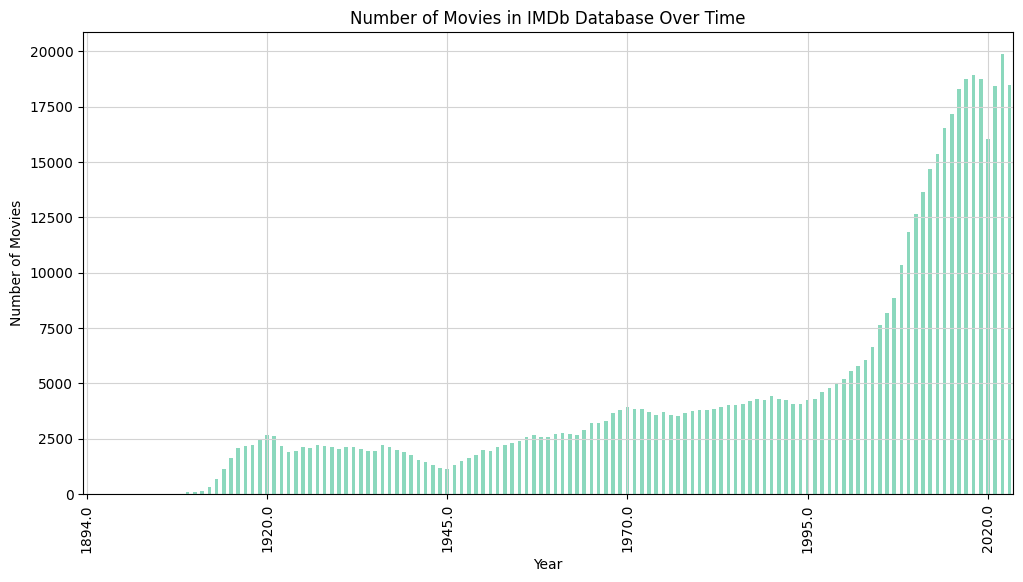

In [74]:
# Aggregating the number of movies released each year.
# This aggregation helps in visualizing trends in movie production over time.
movies_per_year = movies.groupby('startYear').size()

# Plotting the annual movie counts to visually analyze trends in movie production.
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='bar', color='#8BD8BD')
plt.title('Number of Movies in IMDb Database Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(range(0, len(movies_per_year), 25), labels=movies_per_year.index[::25]) # Adjust x-axis to show labels for every 25 years
plt.grid(True, color='#D3D3D3')  # Adding light grey grid lines for better readability
plt.show()


A lot more movies are made in the 21st century than previous centuries. This is probably due to the spread of the internet in the late 90s, which led to a shift towards digital filmmaking and distribution. This made it easier to produce and distribute films. To have a representative look at what the movie industry looks like today, we'll narrow down the dataset to movies released from 2000 to 2023 (present year).

In [30]:
# Narrowing down the dataset to include movies released from 2000 to 2023.
# This will serve as the data to build the film-maker collaboration network later on
movies_2000_2023 = movies[(movies['startYear'] >= 2000) & (movies['startYear'] <= 2023)]

# Displaying the first few rows of this subset
movies_2000_2023.head()

,tconst,startYear,genres
11634,tt0011801,2019.0,"Action,Crime"
13079,tt0013274,2021.0,Documentary
15174,tt0015414,2000.0,\N
27745,tt0028248,2022.0,Musical
34798,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [31]:
# Counting unique values in each column of our final dataset.
# This step provides insights into the diversity of data we'll be working with.
movies_2000_2023.nunique()

tconst       313675
startYear        24
genres         1192
dtype: int64

We have 313,675 movies released between 2000 and 2023. 

In [32]:
# Saving the DataFrame to a CSV file for future use
# 'index=False' omits the index column in the saved file
movies_2000_2023.to_csv('movies_2000_2023.csv', index=False)

# 2. Exploring movie trends through data visualization

Now, let's create some visualizations using the dataset we just created to explore different trends in the film industry, such as changes in movie production volume and genre popularity over time.

## How many movies are we getting each year? 🎬 

First up, we're looking at how many movies were released each year from 2000 to 2023. For this, we'll use a bar chart - each bar represents a year, and its height shows us how many movies came out. From this graph, we can see how the film industry's output has changed over the years. 

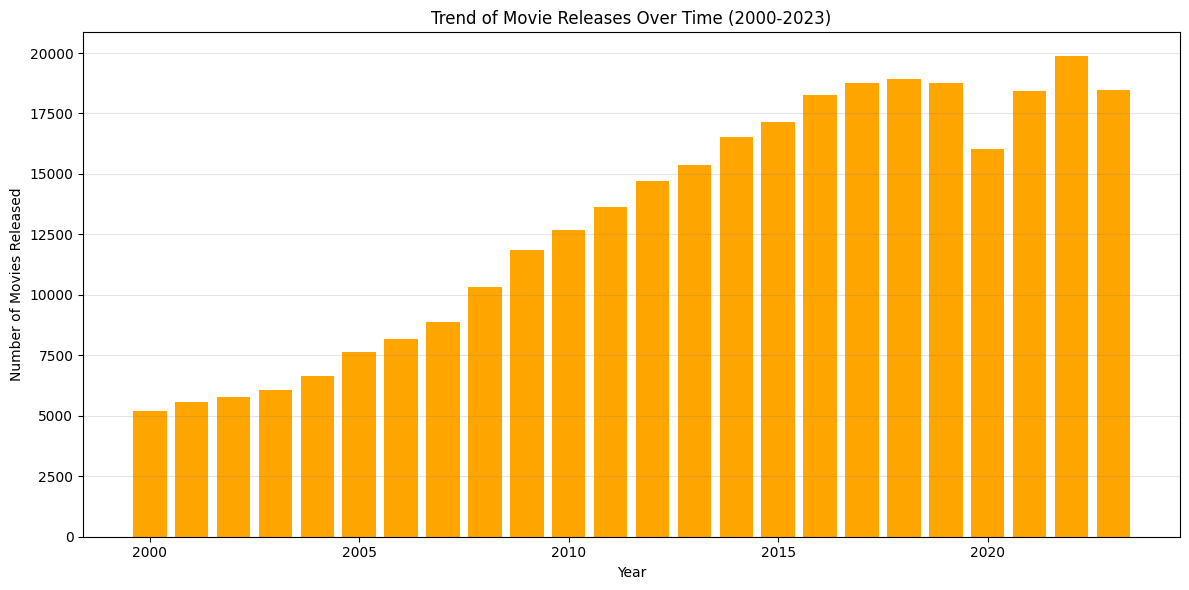

In [6]:
# Group by startYear and count the number of movies to understand the annual production trends.
movies_by_year = movies_2000_2023.groupby('startYear').size()

# Plotting a bar chart to visually represent the number of movies released each year.
plt.figure(figsize=(12, 6))
plt.bar(movies_by_year.index, movies_by_year.values, color='orange')
plt.title('Trend of Movie Releases Over Time (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(axis='y', color='grey', alpha=0.2) # Add a light grid for better readability.
plt.tight_layout()
plt.show()

Most of the time, the number of movie releases steadily increases every year. However, there’s a clear dip in 2020 - likely due to the pandemic affecting productions and releases. But there was the quick rebound in the following years, thanks to the shift to streaming services. It is also interesting to see that shake-ups like the 2007-2008 writers' strike and the 2008 recession didn't slow down the movie-making machine - there was a consistent rise in movie releases annually during this period. The industry's resilience is pretty impressive!

## What's everyone watching? Exploring genre popularity 🍿

Next, we dive into genres. By categorizing movies into genres and visualizing the top 10 with a donut chart, we get a clear picture of genre popularity. Each slice of the donut represents a genre, and its size shows how prevalent that genre has been. It's like a flavor wheel for movies!

In [ ]:
# Preparing data for genre distribution visualization

# Splitting the genres column into lists to facilitate filtering of genres.
movies_2000_2023['genres'] = movies_2000_2023['genres'].str.split(',')

# Removing movies with empty genre lists to ensure all movies considered have relevant genres.
movies_2000_2023 = movies_2000_2023[movies_2000_2023['genres'].map(bool)]

# Expanding the genres column so that each genre of a movie is treated as a separate data point.
expanded_genres = movies_2000_2023.explode('genres')

# Exclude movies with unspecified genres (represented by '\N').
expanded_genres = expanded_genres[expanded_genres['genres'] != '\\N']

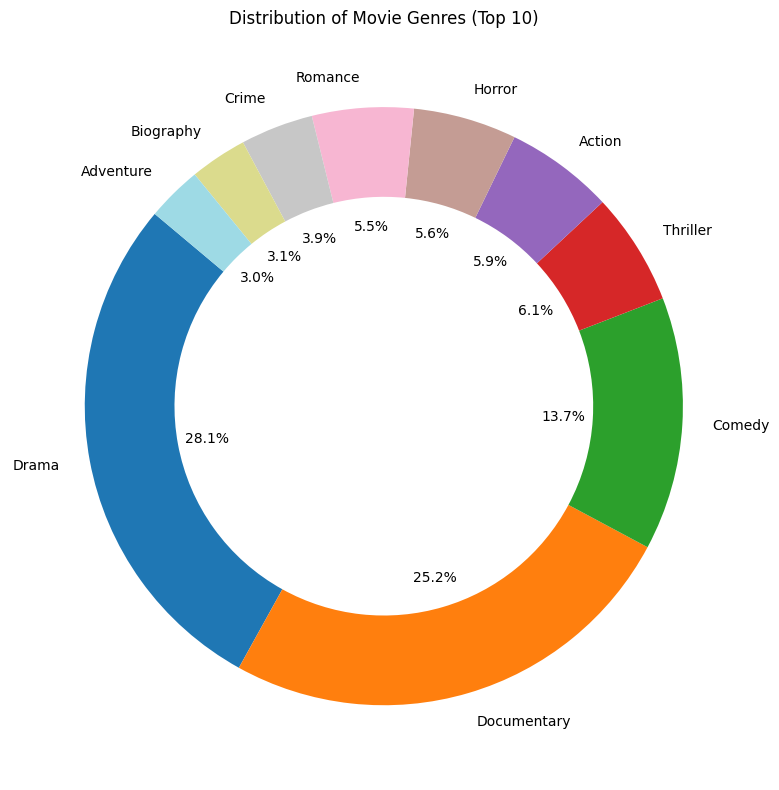

In [64]:
# Genre distribution (top 10 genres) visualization

# Calculating the distribution of genres across all years to understand popular trends.
genre_distribution = expanded_genres['genres'].value_counts(normalize=True) * 100

# Focusing on the top 10 genres for a clearer visualization.
top_genres = genre_distribution.head(10)

# Assigning unique colors to each of the top genres for visual distinction.
unique_colors = plt.cm.tab20(np.linspace(0, 1, len(top_genres)))

# Plotting a donut chart to visualize the proportion of top genres, using 'wedgeprops' to create the donut effect.
plt.figure(figsize=(8, 8))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140, colors=unique_colors, wedgeprops=dict(width=0.3))
plt.title('Distribution of Movie Genres (Top 10)')

plt.tight_layout()
plt.show()


Drama, documentaries, and comedies top the chart! Makes sense since drama and comedies appeal to a wide range of audiences whereas documentaries are relatively inexpensive to produce compared to other genres. 

We can also create a word cloud based on the frequency of each genre. The bigger the genre's name appears, the more movies there are in that genre. Besides the donut chart, it's another fun way to show which genres are most prevalent.

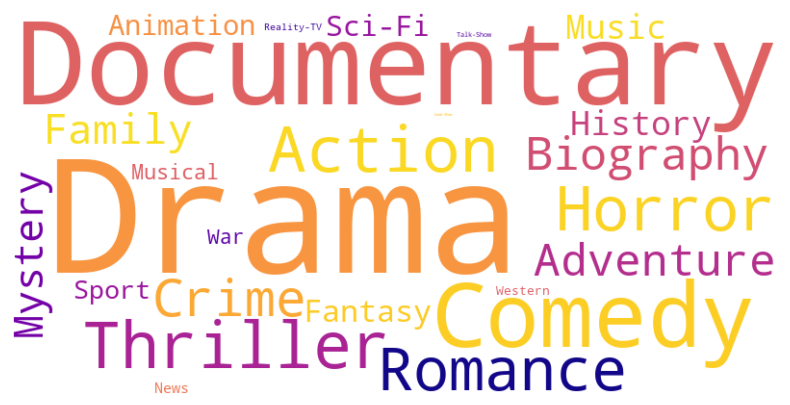

In [62]:
# Word cloud visualization

# Calculate the frequency of each genre in the dataset to understand genre prevalence.
genre_frequencies = expanded_genres['genres'].value_counts().to_dict()

# Create a word cloud visualization using the frequencies dictionary. Here, we use size to indicate the relative frequency of each genre
wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap='plasma').generate_from_frequencies(genre_frequencies)

# Display the word cloud using matplotlib, setting interpolation to 'bilinear' for smoothness.
# The axis is turned off to focus solely on the word cloud visualization.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis for cleaner visualization
plt.show()

## Genre trends through the decades 🕰️ 

Are Drama, Documentary, and Comedy always the most popular genres over time? Let's take a journey through the decades and divide our timeline into three periods: the 2000s, the 2010s, and the early 2020s. Then, we'll make a donut chart for each. From there, we'll be able to see how our cinematic preferences have evolved through the years.

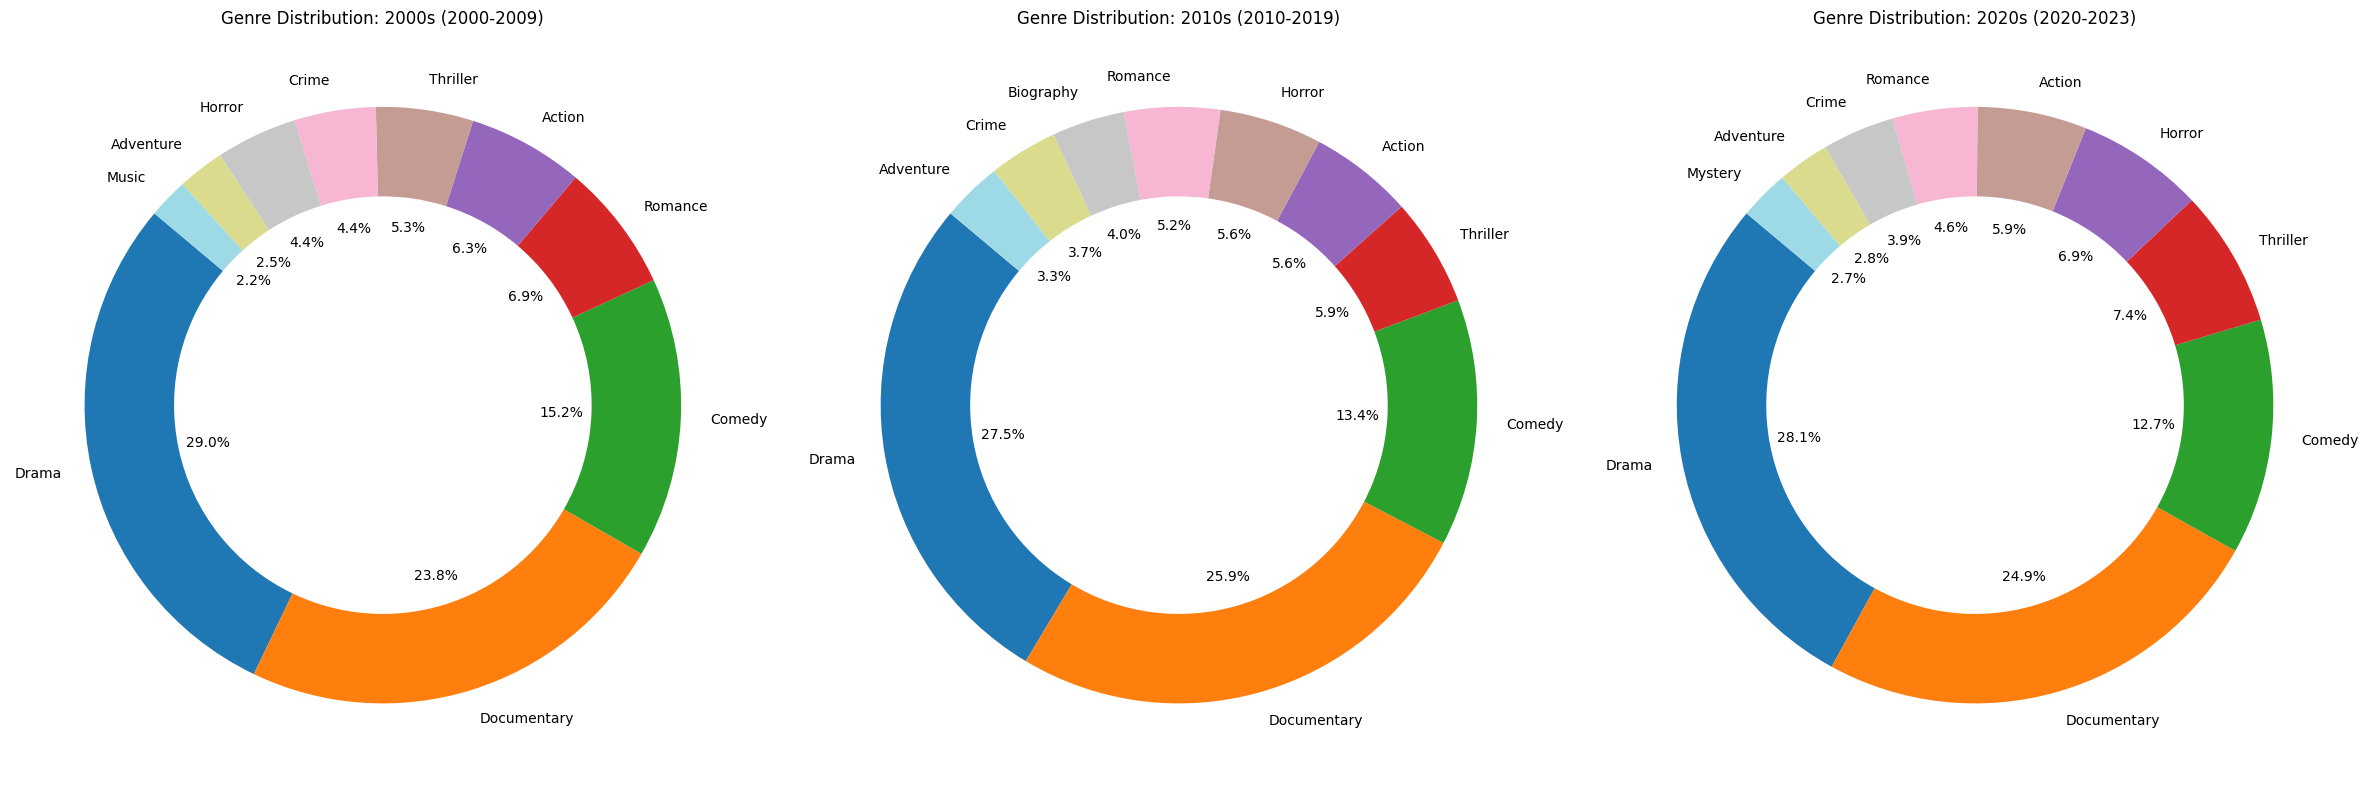

In [48]:
# Time-segmented genre distribution visualization

# Define consolidated time periods for creating segmented donut charts. This categorization allows
# us to compare genre distributions across different eras within our dataset, highlighting how
# genre preferences have evolved over time.
consolidated_periods = {
    '2000s (2000-2009)': (2000, 2009),
    '2010s (2010-2019)': (2010, 2019),
    '2020s (2020-2023)': (2020, 2023),
}

# Prepare the figure for the donut charts with a subplot for each time period defined above.
# This arrangement facilitates direct visual comparison between different eras.
fig, axs = plt.subplots(1, len(consolidated_periods), figsize=(24, 8))  # One row, with a subplot for each time period

# Iterate through each time period, filtering the data accordingly and calculating the top genres for that period.
for idx, (period_label, (start_year, end_year)) in enumerate(consolidated_periods.items()):
    # Filter the data for the current time period
    period_data = expanded_genres[(expanded_genres['startYear'] >= start_year) & (expanded_genres['startYear'] <= end_year)]
    
    # Calculate genre distribution for the current period to identify the most popular genres.
    genre_distribution_period = period_data['genres'].value_counts(normalize=True) * 100
    top_genres_period = genre_distribution_period.head(10)
    
    # Generate unique colors for each genre to enhance visual distinction in the donut chart.
    unique_colors_period = plt.cm.tab20(np.linspace(0, 1, len(top_genres_period)))
    
    # Plotting a Donut Chart for the current period with custom colors and a wedge to denote segmentation.
    # Each chart represents the genre distribution within its respective time period.
    axs[idx].pie(top_genres_period, labels=top_genres_period.index, autopct='%1.1f%%', startangle=140, colors=unique_colors_period, wedgeprops=dict(width=0.3))
    axs[idx].set_title(f'Genre Distribution: {period_label}')

# Adjust the layout to ensure that each donut chart is clearly visible and the overall visualization is well-organized. 
plt.tight_layout()
plt.show()

It seems like Drama, Documentary, and Comedy remain steadfast favorites. However, there are also fluctuations. For example, the fourth and fifth most popular genres in the 2000s are Comedy and Romance, while in the 2010s they are Thriller and Action (reflecting the rise of superhero movies and the decline of romantic comedy movies?) and in the early 2020s they are Thriller and Horror (a renaissance of horror?). This hints at an audience's growing appetite for adrenaline and chills.

Now, I want to see which movie genres have been gaining popularity and which ones might be losing. 📈📉 We'll compare the start and end of our timeline and create a horizontal bar chart. In this chart, genres that have seen an increase in percentage displayed on the left and those with a decrease on the right. Each bar represents a different genre, with the length of the bar indicating the magnitude of the change.

In [25]:
# Counting the number of movies in each genre per year for later analysis of genre popularity changes.
genre_counts_per_year = expanded_genres.groupby(['startYear', 'genres']).size().unstack(fill_value=0)

# Calculating percentages of movies in each genre relative to the total number of movies released that year to understand their relative popularity over time.
genre_percentages_per_year = genre_counts_per_year.div(genre_counts_per_year.sum(axis=1), axis=0) * 100

# Identifying the percentage change for each genre from the first to the last year to spot trends.
first_year_percentage = genre_percentages_per_year.iloc[0]
last_year_percentage = genre_percentages_per_year.iloc[-1]
percentage_change = last_year_percentage - first_year_percentage

# Sort genres by the change to ensure a coherent plot
percentage_change_sorted = percentage_change.sort_values()

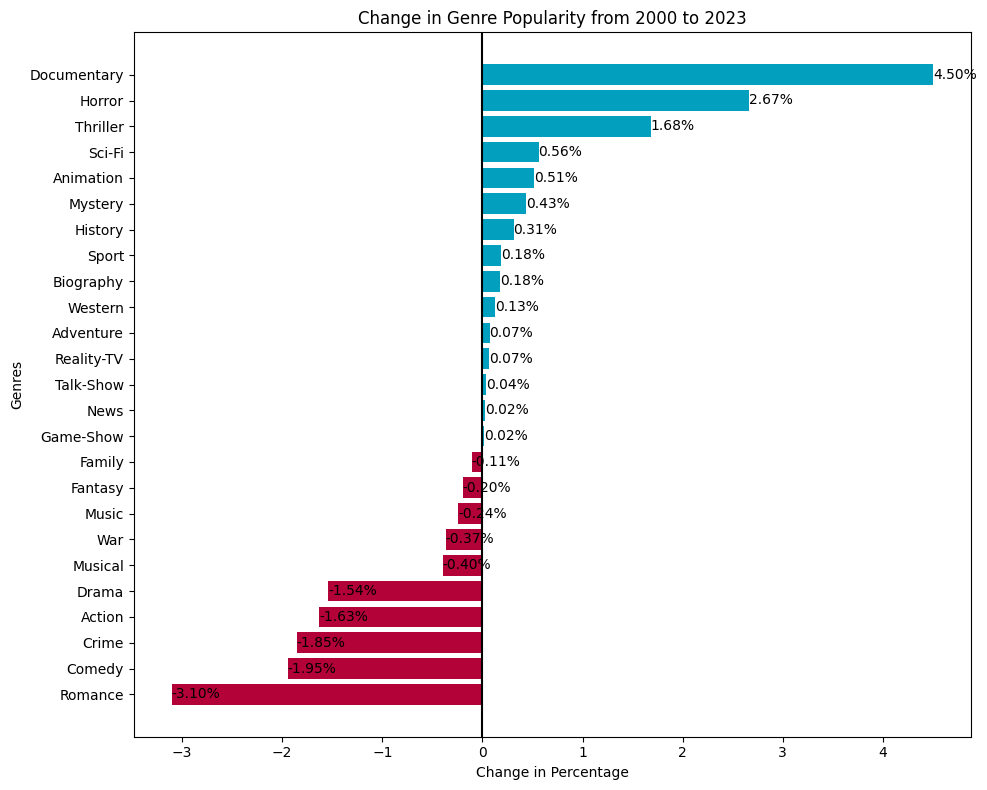

In [32]:
# Plotting a horizontal bar chart to illustrate the change in popularity for each genre.
plt.figure(figsize=(10, 8))
bars = plt.barh(percentage_change_sorted.index, percentage_change_sorted.values, color=np.where(percentage_change_sorted > 0, '#039fbe', '#b20238'))
plt.axvline(0, color='black', linewidth=1.5)  # Marking the no-change point for reference.
plt.title('Change in Genre Popularity from 2000 to 2023')
plt.xlabel('Change in Percentage')
plt.ylabel('Genres')

# Adding labels to indicate increase or decrease
for bar in bars:
    width = bar.get_width()
    label_x_pos = bar.get_width() if bar.get_width() < 0 else bar.get_width()
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{'%.2f' % width}%", va='center')

plt.tight_layout()
plt.show()

Looks like Documentaries, Horror, and Thriller are on the rise, while Action, Comedy, Crime, Drama, and Romance have seen a relative decrease in their share of the spotlight. The rest of the genres have remained relatively stable.

However, it is worth noting that although the percentage of Drama, Comedy, Action movies has decreased over time, these genres are still extremely popular today, ranking 1st, 3rd, and 7th in terms of popularity as seen in the donut chart for the years 2020-2023 above. 

And there we have it—an overview of movie industry trends. It's fascinating to see how resilient and adaptive the film industry is. As we wrap up this part of our analysis, we're all set to dive into the next phase: building the filmographies of directors.

# 3. Tracing director careers from debut to 2023

In this section of our notebook, we'll identify film directors who made their debut between 2003 and 2013 and compile the full filmography of these directors up to present day (the year 2023). Let's call this dataset `directors_full_filmography`. Key components include:
- Director Identifier (`nconst`): Uniquely identifies each director, linking them to their filmography.
- Movie Identifier (`tconst`): Associates directors with specific movies they've directed.
- Release Year (`startYear`): Indicates when each movie was directed, crucial for temporal analysis of a director's career progression.
- Genres (`genres`): Shows the genres of movies directed, highlighting directors' genre preferences.
- Debut Year (`firstYear`): The year of each director's debut, important for benchmarking career milestones.
- Ratings (`averageRating`) and Votes (`numVotes`): Incorporates audience reception data, adding a layer of qualitative success metrics to the quantitative output.

In [42]:
# Initial Exploration of Principal Contributors Data
# The 'df_principals' DataFrame contains key contributors to movies, including directors, actors, etc.
# Viewing its structure helps us understand how to extract information specific to directors.
df_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [43]:
# Understanding the Roles in Film Production
# By analyzing the 'category' column, we identify the distribution of different roles within movie productions.
# This is crucial for isolating directors from other types of contributors in the dataset.
df_principals['category'].value_counts()

category
actor                  13322849
self                   10448069
actress                10392402
writer                  8435856
director                6951076
producer                3917208
cinematographer         2050878
editor                  1996902
composer                1996779
archive_footage          397891
production_designer      381792
archive_sound              4516
Name: count, dtype: int64

In [37]:
# Isolating Directors
# We filter 'df_principals' to focus only on entries categorized as 'director'.
# This step is essential for later linking directors to their respective movies.
directors = df_principals[df_principals['category'] == 'director']

# Linking Directors to Their Movies
# We merge the 'movies' DataFrame with the filtered 'directors' DataFrame using the 'tconst' identifier.
# This enables us to attribute movies to specific directors 
directors = movies.merge(directors[['tconst', 'nconst']], on='tconst', how='inner')

# Identifying Directors' Debut Films
# By grouping the data by director and finding the earliest 'startYear', we identify each director's debut film.
directors_first_movies = directors.groupby('nconst').agg({'startYear': 'min'}).reset_index()

# Renaming the aggregated column to denote it as the year of the director's first movie
directors_first_movies = directors_first_movies.rename(columns={'startYear': 'firstYear'})

# Focusing on Directors Who Debuted Between 2003 and 2013
# We filter directors to include only those whose debut falls within our period of interest.
# This selection allows us to have at least a decade view into a director's career
debut_directors_2003_2013 = directors_first_movies[(directors_first_movies['firstYear'] >= 2003) & (directors_first_movies['firstYear'] <= 2013)]

# Compiling Full Filmographies
# By filtering the 'directors' DataFrame for our identified debut directors, we compile their complete filmographies.
directors_full_filmography = directors[directors['nconst'].isin(debut_directors_2003_2013['nconst'])]

# Merging with debut information allows us to retain knowledge of each director's first year in the industry.
directors_full_filmography = directors_full_filmography.merge(debut_directors_2003_2013, on='nconst', how='left')

In [55]:
# Counting the unique counts for an overview of the compiled filmographies
directors_full_filmography.nunique()

tconst       115413
startYear        21
genres          948
nconst        63169
firstYear        11
dtype: int64

So, our data includes the complete filmographies of 63,169 directors, capturing every movie they've directed since their debut (a total of 115,413 movies). 

In [56]:
# Integrating IMDb Ratings
# Accessing and merging IMDb's 'title.ratings' dataset enhances our filmography data with public reception metrics.
# This inclusion of ratings and votes offers an additional layer of analysis for evaluating directors' works.
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
df_ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip')

# Displaying the first few rows of 'df_ratings' for an overview
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2017
1,tt0000002,5.7,270
2,tt0000003,6.5,1943
3,tt0000004,5.4,178
4,tt0000005,6.2,2721


In [57]:
# Merge the ratings data with the 'directors_full_filmography' dataset
# This adds IMDb ratings and number of votes to the filmography data
directors_full_filmography = directors_full_filmography.merge(df_ratings, on='tconst', how='left')

# Save the 'directors_full_filmography' dataset to a CSV file for future use
directors_full_filmography.to_csv('directors_full_filmography.csv', index=False)

In [2]:
# taking a look at the structure of the data
directors_full_filmography

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0
...,...,...,...,...,...,...,...
128529,tt9916362,2020.0,"Drama,History",nm1893148,2008.0,6.4,5687.0
128530,tt9916538,2019.0,Drama,nm4457074,2011.0,8.6,7.0
128531,tt9916622,2015.0,Documentary,nm9272490,2012.0,NaN,NaN
128532,tt9916754,2013.0,Documentary,nm9272490,2012.0,NaN,NaN


# 4. Understanding director filmography through data visualization 

Now that we've got all this data on directors who started their journeys between 2003 and 2013, let's create some  visuals to get a grasp on what's been happening in their careers, the genres they explore, and how their work is received by audiences.

## A closer look at director productivity 

Starting off, I'm curious about how many movies these directors have crafted after their debut. Let's visualize this with a bar chart showing us how many have gone on to direct more movies.


In [3]:
# Initialize a DataFrame to track each director's career progression after their debut.
# It includes a unique identifier for each director ('nconst') and their debut year ('firstYear').
post_debut_director_movies = directors_full_filmography[['nconst', 'firstYear']].drop_duplicates()

# Initially assume all directors have directed zero movies after their debut
# This assumption will be updated based on the actual data 
post_debut_director_movies['movies_directed_after_first'] = 0

# Filter the full filmography to include only movies directed after the director's first movie
# This helps in focusing on the directors' career progression after their debut
movies_after_debut = directors_full_filmography[directors_full_filmography['startYear'] > directors_full_filmography['firstYear']]

# Group the data by director and count the number of movies directed after their debut
movies_count_after_debut = movies_after_debut.groupby('nconst').size()

# Update our initial DataFrame with these counts to reflect directors' productivity after their debut.
post_debut_director_movies.set_index('nconst', inplace=True)
post_debut_director_movies.loc[movies_count_after_debut.index, 'movies_directed_after_first'] = movies_count_after_debut
post_debut_director_movies.reset_index(inplace=True)

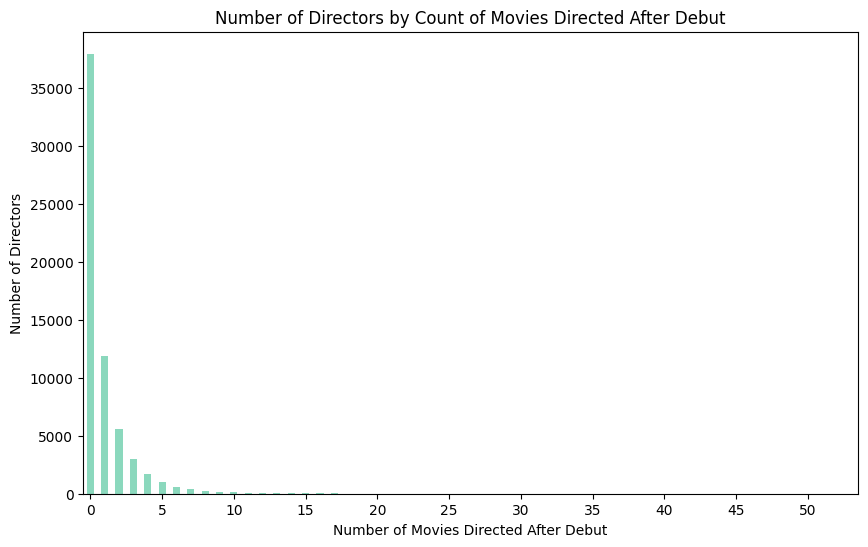

In [5]:
# Visualize the productivity of directors after their debut by counting the number of movies directed.
plt.figure(figsize=(10, 6))
director_counts_by_movie_number = post_debut_director_movies['movies_directed_after_first'].value_counts().sort_index()
director_counts_by_movie_number.plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Number of Directors by Count of Movies Directed After Debut')
plt.xlabel('Number of Movies Directed After Debut')
plt.ylabel('Number of Directors')

# Adjust the x-axis to show labels for every 5 movies for better readability
xticks = range(0, len(director_counts_by_movie_number), 5)
plt.xticks(ticks=xticks, labels=[str(i) for i in xticks], rotation=0)

plt.show()

Wow, it looks like a good number of directors haven't directed anything after their initial movie. Let's dig a bit deeper with some stats to get a better sense of their productivity. 

In [6]:
# Get an overview of the distribution and central tendencies of the number of movies directed after debut
post_debut_director_movies['movies_directed_after_first'].describe()

count    63169.000000
mean         1.010021
std          2.359699
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        126.000000
Name: movies_directed_after_first, dtype: float64

Things seem stark in the film industry. The median and mode being 0 indicate that at least half of the directors did not produce any movie post-debut. The third quartile is 1, suggesting that 75% of directors directed one movie or fewer after their debut. A large standard deviation, alongside a wide range, points to a significant disparity in career trajectories among directors, with a few directors being exceptionally prolific, which skews the average slightly higher than the median and mode.

This shows that while there is a small group of directors who achieved exceptional productivity, the overall picture is one of considerable challenge with most directors directing no movies after their debut. It's a stark reminder how competitive the director career is.

## Genre choices for directorial debuts

Next up, we're exploring the genres these directors chose for their debut films. For this, we'll create a heatmap showing the prevalence of each genre among debut movies. The color intensity represents the count of directors who debuted with movies in specific genres, with darker colors indicating higher frequencies. This visualization tells us which genres that are seen as accessible or appealing for directorial debuts.

In [28]:
# Prepare the data for visualization of genre distribution among directors in their debut movie

# Filter to get only the debut movies for each director
debut_movies = directors_full_filmography[directors_full_filmography['startYear'] == directors_full_filmography['firstYear']].drop_duplicates()

# Split genres - each movie can have multiple genres, we treat each genre independently
# This involves creating a new row for each genre associated with a movie
debut_movies_genres_split = debut_movies.assign(genres=debut_movies['genres'].str.split(',')).explode('genres')

# Remove rows where genre is 'Adult' or '\N'
debut_movies_genres_split = debut_movies_genres_split[~debut_movies_genres_split['genres'].isin(['Adult', '\\N'])]

# Now, merge the genre information with the count of movies directed after debut
debut_movies_genres_split = pd.merge(debut_movies_genres_split, post_debut_director_movies, on='nconst')

# Count how frequently each genre appears in directors' debut movies.
genre_distribution = debut_movies_genres_split.groupby('genres').size()

# Convert the series to a DataFrame for visualization
genre_distribution_df = genre_distribution.reset_index(name='count').pivot_table(index='genres', values='count', aggfunc='sum')

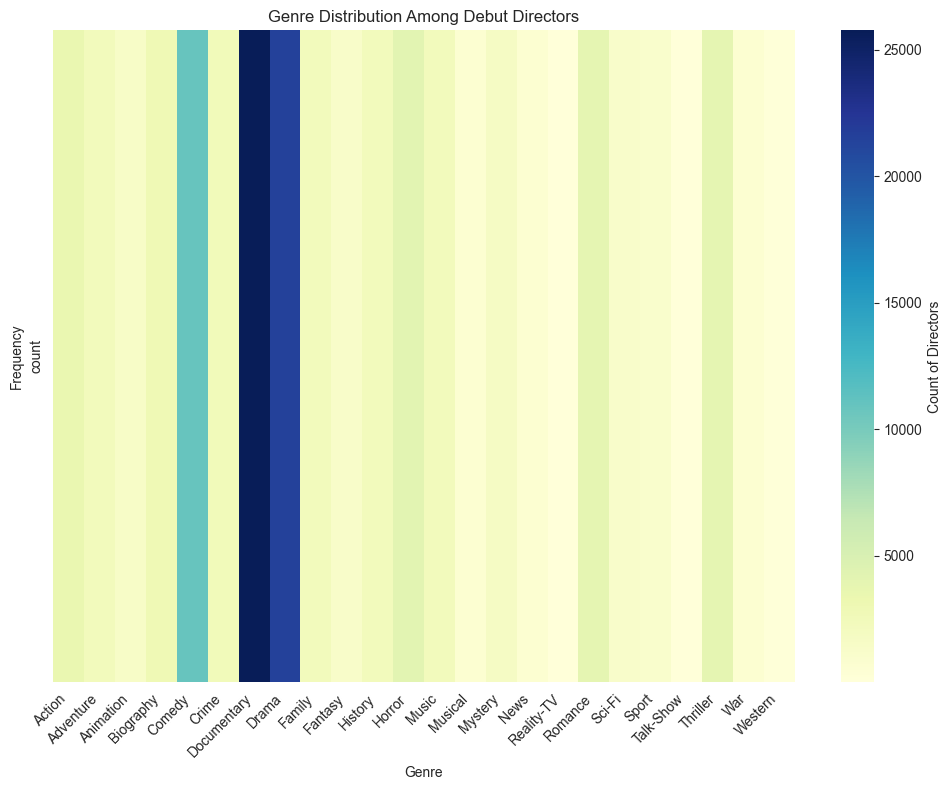

In [29]:
# Create a heatmap to visualize the distribution of genres among debut movies, offering insight into popular genres for debut directors.
plt.figure(figsize=(10, 8))
sns.heatmap(genre_distribution_df.T, cmap='YlGnBu', cbar_kws={'label': 'Count of Directors'})

plt.title('Genre Distribution Among Debut Directors')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


From the heatmap above, we see that Documentary, Drama, and Comedy are the go-to genres for many first-time directors. Horror, Thriller, and Romance, to a lesser extent, are also popular choices. Perhaps these genres offer a canvas that's both accessible and expressive for budding storytellers.

## Audience's ratings for debut movies

Now, let's explore about how these debut films were received. We'll box plots to compare average ratings across genres. Each box represents the interquartile range (IQR) of ratings within a genre, with the line inside the box marking the median rating. This visualization helps us understand which genres among debut movies tend to receive higher or lower ratings, giving us clues about what makes a debut film stand out.

In [30]:
# Prepare the data for the box plot visualization
# Since movies can have multiple genres, we expand the dataset so each genre of a movie is considered separately
genres_expanded_ratings = debut_movies.drop('genres', axis=1).join(debut_movies['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genre')).reset_index(drop=True)

# Exclude genres with missing names ('\N') for a cleaner visualization
genres_expanded_ratings = genres_expanded_ratings[~genres_expanded_ratings['genre'].isin(['Adult', '\\N'])]

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1177/567245301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=genres_expanded_ratings, x='averageRating', y='genre', palette='coolwarm', order=genres_ordered_by_median_ratings)


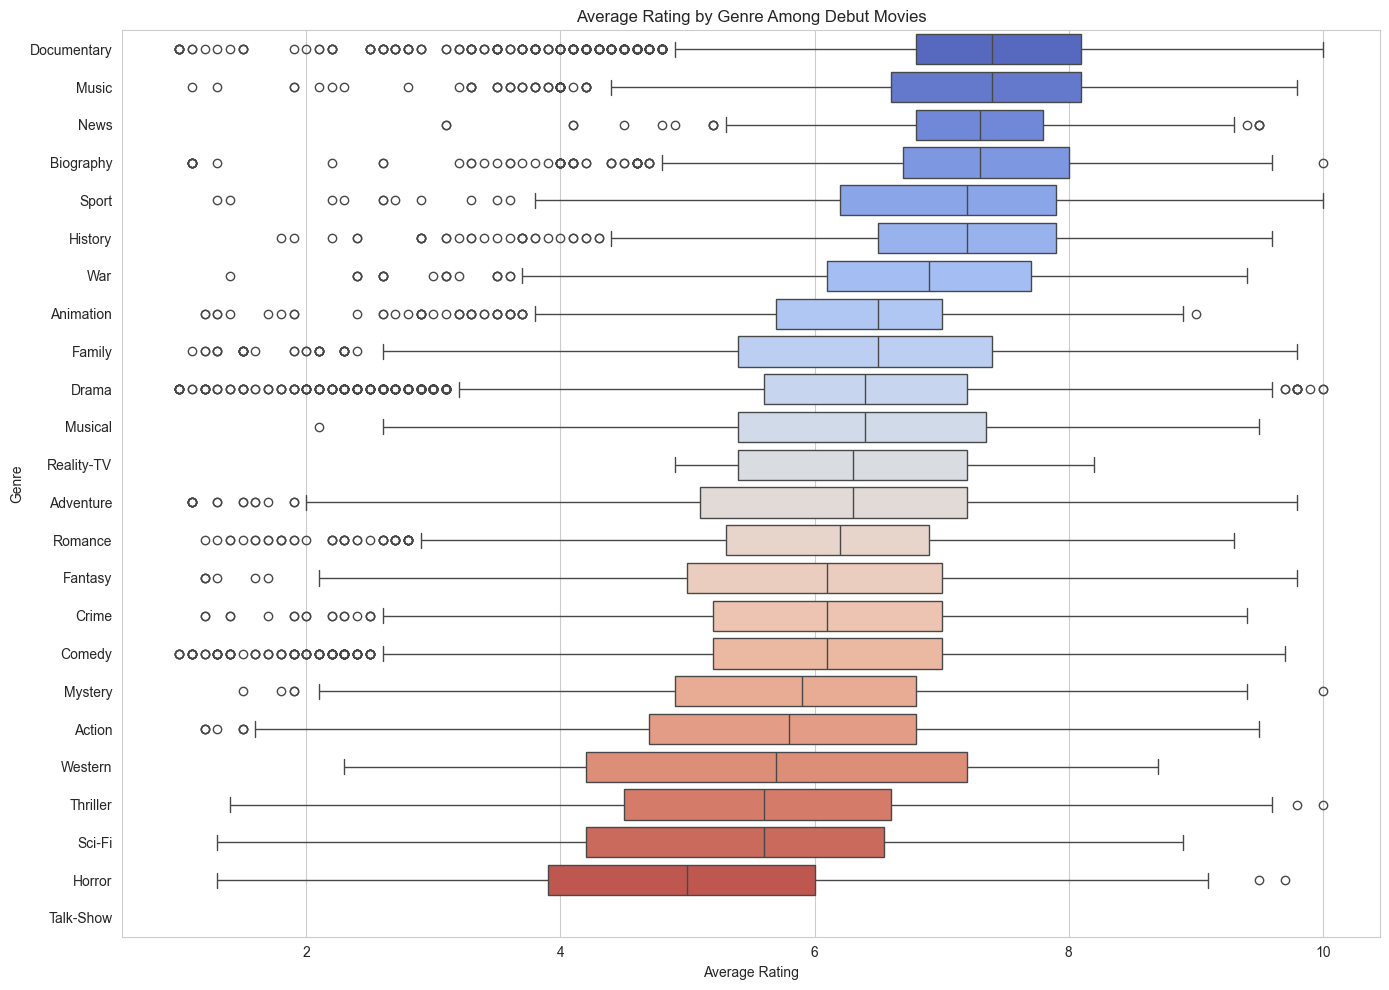

In [32]:
# Order genres by their median ratings to prepare for the box plot visualization, highlighting the average reception of debut movies by genre.
genres_ordered_by_median_ratings = genres_expanded_ratings.groupby('genre')['averageRating'].median().sort_values(ascending=False).index

# Create a box plot to compare the average ratings of debut movies across different genres.
plt.figure(figsize=(14, 10))
sns.boxplot(data=genres_expanded_ratings, x='averageRating', y='genre', palette='coolwarm', order=genres_ordered_by_median_ratings)
plt.title('Average Rating by Genre Among Debut Movies')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

The genres that tend to perform better (those with high median ratings) are Documentary, Music, News, and Biography. On the lower end, genres like Western, Action, Thriller, Sci-Fi, and Horror show lower median ratings.

The genres that show more variability in ratings (those with high IQR) among debut directors' movies are News, Documentary, suggesting that ratings within these genres are more consistent. On the lower end, Western and Sci-Fi exhibit most variability in their ratings. Horror, despite its lower median rating, also shows significant variability in how it's received.

It seems like genres associated with factual content (e.g., Documentary, News, Biography) not only perform better on average but also show less variability in their reception. This might be because they show a consistent quality or because the audience's expectations align well with the output in these genres. In constrast, creative or speculative genres (e.g., Sci-Fi, Fantasy, Horror) tend to have more variability in reception and, in some cases, lower median ratings. This might be because audience's expectations for these genres are diverse and thus it is hard to please everyone. 

## Vote counts across genres among debut movies 

While ratings tell us one part of the story, vote counts offer another perspective - how engaged were viewers with these debut films? Again, we turned to box plots, this time on a logarithmic scale, to navigate through the wide range of vote counts among different genres. This visualization highlights which genres attract viewer interest and inspire viewers to rate or review.

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_2159/897819109.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=genres_expanded_ratings, x='numVotes', y='genre', palette='viridis', order=genres_ordered_by_median_votes)


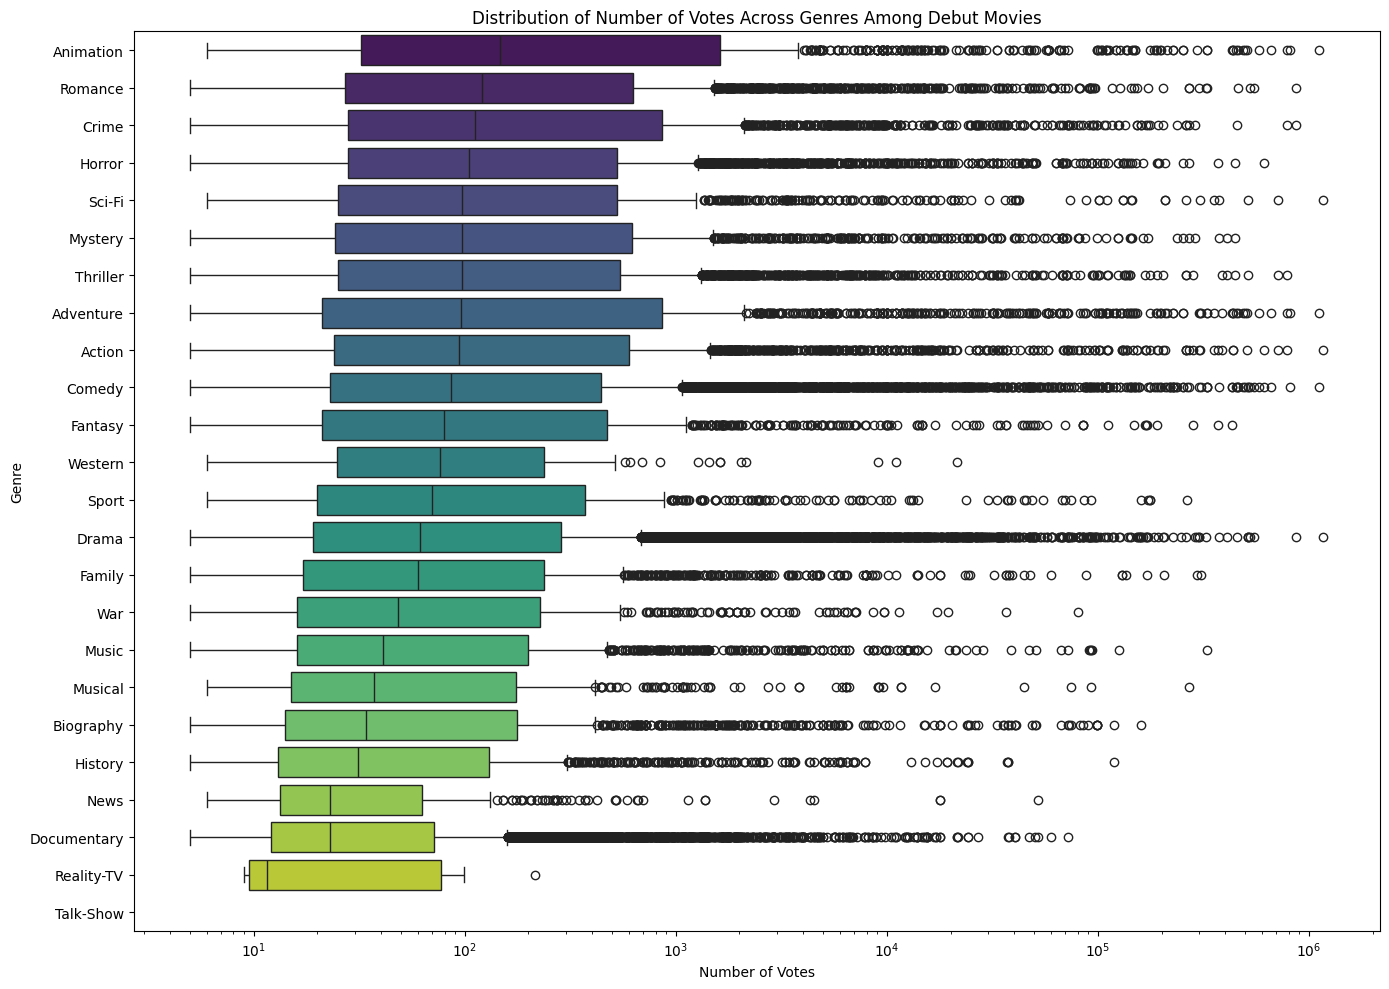

In [75]:
# Order genres by their median number of votes to analyze audience engagement with debut movies by genre.
genres_ordered_by_median_votes = genres_expanded_ratings.groupby('genre')['numVotes'].median().sort_values(ascending=False).index

# Visualize the distribution of audience votes across genres for debut movies using a box plot with a logarithmic scale.
plt.figure(figsize=(14, 10))
sns.boxplot(data=genres_expanded_ratings, x='numVotes', y='genre', palette='viridis', order=genres_ordered_by_median_votes)
plt.title('Distribution of Number of Votes Across Genres Among Debut Movies')
plt.xlabel('Number of Votes')
plt.ylabel('Genre')
plt.xscale('log')  # Use a logarithmic scale to better display the wide range of values
plt.tight_layout()
plt.show()


Animation and Romance stand out with the highest median number of votes, suggesting these genres tend to pull in more engagement. In contrast, Documentary, though often highly rated, doesn't always spark the same level of viewer activity.

The interquartile range (IQR) offer additional insights into the variability of popularity within genres. For example, Animation, despite its high average engagement, shows a large IQR, indicating a wide variability in the number of votes across movies within this genre. In contrast, genres like News and Documentary, while less popular on average, exhibit smaller IQRs, suggesting more consistency in the number of votes their movies receive.

Overall, genres like Animation and Adventure not only show high average engagement but also a significant range in engagement levels, suggesting that while hits are possible, there's also a considerable range in audience reception. In constrast, Documentary and News genres, with their lower engagement levels, still offer a degree of predictability in audience size.

# 5. Examining career before directorial debut

Some first-time directors might have worked on other movies in non-directing roles before they started directing. This prior experience might influence their career longevity as a director. Therefore, in this part of our analysis, we're creating a dataset called `directors_experience` detailing the extent and nature of their involvement in movie productions prior to their first directorial project. This data will include:
- Director Identifier (`nconst`): Uniquely identifies each director.
- Pre-Debut Movie Count (`movie_count`): The number of movies a director worked on in any capacity before their debut, providing a measure of their industry involvement.
- Pre-Debut Roles (`roles`): Lists the variety of roles undertaken by directors, offering a glimpse into their background and skill set.
- Prior Experience Flag (`had_prior_experience`): A binary indicator showing whether directors had any film industry experience before directing their first movie.

In [75]:
# Narrowing down the principal dataset to entries corresponding to our identified debut directors. 
# This captures the full range of roles they've engaged in across film productions, not limited to directing roles. 
# It sets the stage for a comprehensive analysis of their industry involvement before they made their directorial debut.
director_roles_pre_debut = df_principals[(df_principals['nconst'].isin(debut_directors_2003_2013['nconst']))]

# Merging this filtered dataset with the movies dataset to align each role with its corresponding movie's release year
# This provides a temporal dimension to their career paths.
director_roles_pre_debut = director_roles_pre_debut[['tconst', 'nconst', 'category']].merge(movies[['tconst', 'startYear']], on='tconst', how='inner')

# Including each director's debut year (from the debut directors dataset) in this merged dataset
# This helps distinguish the professional activities undertaken before stepping into the directorial role.
director_roles_pre_debut = director_roles_pre_debut.merge(debut_directors_2003_2013, on='nconst', how='left')

# Filtering for work that occurred before their directorial debut.
pre_debut_work = director_roles_pre_debut[director_roles_pre_debut['startYear'] < director_roles_pre_debut['firstYear']]

# Excluding instances where their role was 'self'.
pre_debut_work = pre_debut_work[pre_debut_work['category'] != "self"]

# Aggregating the data to count the number of movies each director was involved in before their debut and the variety of roles they held. 
# This reveals the breadth and depth of their industry experience.
pre_debut_experience = pre_debut_work.groupby('nconst').agg({
    'tconst': 'count', 
    'category': lambda x: list(set(x))
    }).rename(columns={'tconst': 'movie_count', 'category': 'roles'})

# Initializing a DataFrame to systematically record each director's pre-debut experience.
# Initially, all directors are marked with '0' to indicate an assumption of no prior experience, which we will update based on our findings.
directors_experience = pd.DataFrame({'nconst': directors_full_filmography['nconst']}).drop_duplicates()
directors_experience['had_prior_experience'] = 0  # Initializing with 0 (no experience)

# Merging this data with the detailed pre-debut experience data, including the count of movies and the roles before their directorial debut.
directors_experience = directors_experience.merge(pre_debut_experience, on='nconst', how='left')

# Filling missing values (NaNs) with 0 for directors without prior experience

# Filling in '0' for directors who have not held any roles before their debut to indicate no prior experience
directors_experience['movie_count'].fillna(0, inplace=True)

# Updating the 'had_prior_experience' indicator to '1' for directors who have documented activities before their debut
directors_experience.loc[directors_experience['movie_count'] > 0, 'had_prior_experience'] = 1

In [93]:
# Taking a look at the data
directors_experience

,nconst,had_prior_experience,movie_count,roles
0,nm1131265,0,0.0,NaN
1,nm1130611,0,0.0,NaN
2,nm0290651,0,0.0,NaN
3,nm0404033,0,0.0,NaN
4,nm0000417,1,14.0,"['archive_footage', 'actor']"
...,...,...,...,...
63164,nm4394847,0,0.0,NaN
63165,nm10527671,0,0.0,NaN
63166,nm10532602,0,0.0,NaN
63167,nm4453202,0,0.0,NaN


In [123]:
# Counting the number of directors by pre-debut movie counts
directors_experience['movie_count'].value_counts().sort_index()

movie_count
0.0      52850
1.0       5774
2.0       1820
3.0        842
4.0        473
         ...  
106.0        1
112.0        1
124.0        1
160.0        1
163.0        1
Name: count, Length: 76, dtype: int64

The majority of first-time directors (84%) did not work in other movie productions before their directing debut. 

# 6. Understanding pre-directing career through visualization

Let's focus on those who did have prior experience and create a bar chart to visualize the occurrences of roles undertaken by directors before their directorial debut. This can give us insights into common pathways to becoming a director, highlighting if certain roles are more frequently stepping stones to directorial positions.

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_1177/1982490231.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=roles_df, x='Count', y='Role', palette='coolwarm')


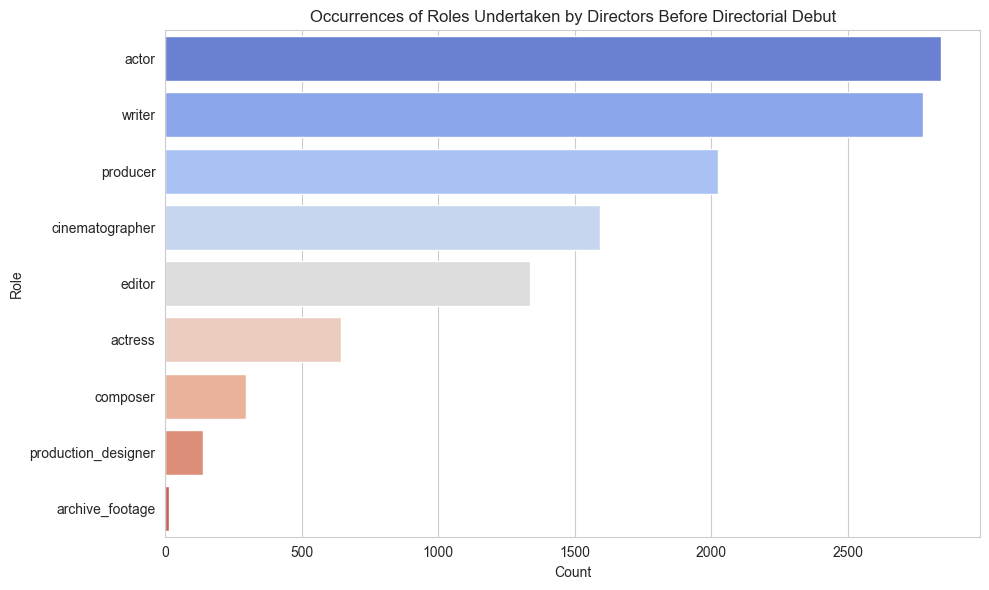

In [42]:
# Creating a bar chart to show the diversity and frequency of the different roles taken by first-time directors before their debut

# Filter directors who had prior experience
directors_with_experience = directors_experience[directors_experience['had_prior_experience'] == 1]

# Initialize a counter for roles
roles_counter = Counter()

# Iterate through each row, safely evaluate the 'roles' column as a list, and update the counter
for roles_list in directors_with_experience['roles'].dropna():
    roles = ast.literal_eval(roles_list)
    roles_counter.update(roles)

# Convert the counter to a DataFrame for easier plotting
roles_df = pd.DataFrame(roles_counter.items(), columns=['Role', 'Count']).sort_values(by='Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=roles_df, x='Count', y='Role', palette='coolwarm')
plt.title('Occurrences of Roles Undertaken by Directors Before Directorial Debut')
plt.xlabel('Count')
plt.ylabel('Role')
plt.tight_layout()
plt.show()

Acting and writing are the most common roles, followed by producing and cinematography. This  suggests a notable pathway into directing, where those with substantial experience in acting or writing are more likely to transition into directing roles.

Let's see if having prior experience in the film industry, in roles other than directing, influences a director's productivity after their debut. We can approach this by using a bar chart to show the average number of movies directed after debut for those with and without prior experience. We can also use a box plot to compare the distribution of movies directed post-debut between them, showing how the outcomes vary among directors within each group.

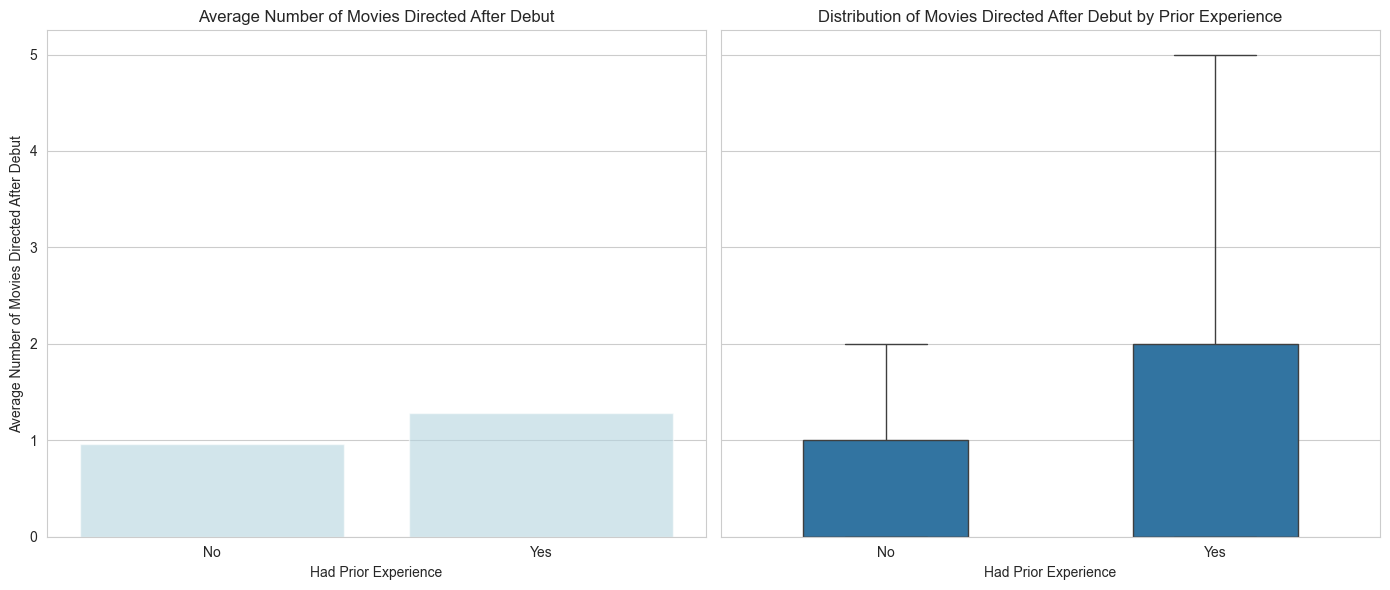

In [48]:
# Combine the new dataset with the previously calculated count of movies directed after debut
combined_experience_data = pd.merge(directors_experience, post_debut_director_movies[['nconst', 'movies_directed_after_first']], on='nconst')

# Convert 'had_prior_experience' to a categorical type for better visualization labels
combined_experience_data['had_prior_experience'] = combined_experience_data['had_prior_experience'].map({0: 'No', 1: 'Yes'})

# Calculate means for plotting
grouped_data = combined_experience_data.groupby('had_prior_experience')['movies_directed_after_first']
means = grouped_data.mean().reset_index()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bar plot for the averages
sns.barplot(ax=axes[0], data=means, x='had_prior_experience', y='movies_directed_after_first', color='lightblue', alpha=0.6)
axes[0].set_title('Average Number of Movies Directed After Debut')
axes[0].set_xlabel('Had Prior Experience')
axes[0].set_ylabel('Average Number of Movies Directed After Debut')

# Box plot for the distribution
sns.boxplot(ax=axes[1], data=combined_experience_data, x='had_prior_experience', y='movies_directed_after_first', showfliers=False, width=0.5)
axes[1].set_title('Distribution of Movies Directed After Debut by Prior Experience')
axes[1].set_xlabel('Had Prior Experience')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


From the bar chart, we can see that average number of movies directed after debut is slightly higher for directors with prior experience, as indicated by the height of the light blue bars.

From the box plot, we can see higher variance among directors with prior experience compared to those without, indicated by the wider interquartile range. However, the median for both groups is 0, meaning that a significant portion of directors (at least 50%), whether with prior experience or not, tends to drop out of directing after their directorial debut. 

In [92]:
# Saving the data for future analysis 
directors_experience.to_csv('directors_pre_debut_careers.csv', index=False)